# Modelagem SEIR
Neste notebook está implementado o modelo SEIR de Zhilan Feng. Que inclui quarentena, e hospitalizações

\begin{align}
\frac{dS}{dt}&=-\beta S (I+(1-\rho)H)\\
\frac{dE}{dt}&= \beta S (I+(1-\rho)H)-(\chi+\alpha)E\\
\frac{dQ}{dt}&=\chi E -\alpha Q\\
\frac{dI}{dt}&= \alpha E - (\phi+\delta)I\\
\frac{dH}{dt}&= \alpha Q +\phi I -\delta H\\
\frac{dR}{dt}&= \delta I +\delta H
\end{align}

Denotando o tamanho total da epidemia por $Y_e(t)=E(t)+Q(t)+I(t)+H(t)$, podemos escrever:

\begin{align}
\nonumber \frac{dY_e}{dt}&= \frac{dE}{dt}+\frac{dQ}{dt}+\frac{dI}{dt}+\frac{dH}{dt}\\
\label{ye}&=\beta S (I(1-\rho)H) -\delta(I+H)
\end{align}


In [1]:
from scipy.integrate import odeint
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
import humanizer_portugues as hp
import seaborn as sns
from datetime import timedelta
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def seqihr(y,t,*params):
    S,E,Q,I,H,R = y
    chi,phi,beta,rho,delta,alpha = params
    return[
        -beta*S*(I+(1-rho)*H), #dS/dt
        beta*S*(I+(1-rho)*H) - (chi+alpha)*E,#dE/dt
        chi*E -alpha*Q,#dQ/dt
        alpha*E - (phi+delta)*I,#dI/dt
        alpha*Q + phi*I -delta*H,#dH/dt
        delta*I + delta*H,#dR/dt
    ]

In [3]:
chi=.05  # Taxa de quarentenação
phi=.01 # Taxa de Hospitalização
beta=.2 #taxa de Transmissão
rho=.6 # Atenuação da transmissão quando hospitalizado
delta=1/10 # Taxa de recuperação hospitalar
alpha=1/3 # Taxa de incubaçao

In [4]:
inits = [0.9,.1,0,0,0,0]
trange = arange(0,100,.1)
res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))

In [5]:

@interact(chi=(0,.1, 0.01),phi=(0,.1,.005),beta=(0,.5,.05),rho=(0,1,.1),delta=(0,1,.05),alpha=(0,1,0.01))
def plota_simulação(chi=0.05,phi=.01,beta=.2,rho=.6,delta=.1,alpha=.33):
    res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))
    fig, ax = subplots(1,1, figsize=(15,10))
    ax.plot(trange,res[:,1:-1])
    ax.set_ylabel('Fração da População')
    ax.set_xlabel('Tempo (dias)')
    ax.grid()
    ax.legend(['Exposto','Quar','Inf','Hosp']);

interactive(children=(FloatSlider(value=0.05, description='chi', max=0.1, step=0.01), FloatSlider(value=0.01, …

## Adicionando Assintomáticos
![Diagrama de blocos](seqiahr.jpg "Modelo")
O modelo de Feng não é apropriado para representar a epidemia da COVID-19. Vamos Modificá-lo para incluir entre outras coisas, os assintomáticos. Para simplificar a notação vamos denotar por $\lambda=\beta(I\color{red}{+A}+(1-\rho)H)$, já incluindo os assintomáticos, $A$.

\begin{align}
\frac{dS}{dt}&=-\lambda S \\
\frac{dE}{dt}&= \lambda S -(\chi+\alpha)E\\
\frac{dQ}{dt}&=\chi E -\color{red}{(\phi+\delta)} Q\\
\frac{dI}{dt}&= \color{red}{(1-p)}\alpha E - (\phi+\delta)I\\
\color{red}{\frac{dA}{dt}}&= \color{red}{p\alpha E -\delta A}\\
\frac{dH}{dt}&= \color{red}{\phi} Q +\phi I -\delta H\\
\frac{dR}{dt}&= \delta I +\delta H \color{red}{+ \delta A +\delta Q}
\end{align}

Neste novo modelo alteramos mais algumas coisinhas resaltadas em vermelho acima. em primeiro lugar fizemos com que a taxa de hospitalização dos quarentenados, seja a mesma que a dos infectados e permitimos que se recuperem sem hospitalização. Além disso, para alimentar a classe dos Assintomáticos, definimos $p$ como a fração de assintomáticos na população. $R_0\approx$

### Adicionando ou removendo a quarentena
Para permitir que a quarentena seja acionada no modelo em uma data definida por um parâmetro $q$, precisamos expressá-la como uma função diferenciável que varie de zero ao nivel de quarentena desejado rapidamente.
\begin{equation}
    \chi(t)=\frac{1+tanh(t-q)}{2}
\end{equation}
Abaixo temos uma exemplificação grafica de $\chi(t)$

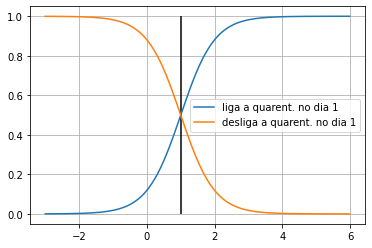

In [6]:
x = arange(-3,6,.01)
d=1
plot(x,(1+tanh(x-d))/2, label=f"liga a quarent. no dia {d}")
plot(x,(1+tanh(x-d)*-1)/2, label=f"desliga a quarent. no dia {d}")
vlines(d,0,1)
grid()
legend();

In [7]:
def seqiahr(y,t,*params):
    S,E,I,A,H,R,C = y
    chi,phi,beta,rho,delta,alpha,p,q = params
    lamb = beta*S*(I+A+(1-rho)*H)
    chi *= (1+np.tanh(t-q))/2 #Liga a quarentena dia q
    return[
        -lamb*((1-chi)*S), #dS/dt
        lamb*((1-chi)*S) - alpha*E,#dE/dt
        (1-p)*alpha*E - (phi+delta)*I,#dI/dt
        p*alpha*E - delta*A,
        phi*I -delta*H,#dH/dt
        delta*I + delta*H+delta*A ,#dR/dt
        phi*I#(1-p)*alpha*E+ p*alpha*E # Casos acumulados
    ]

In [23]:
trange = arange(0,365,1)
inits = [0.99,0,1.0277e-6, 0.0,0,0,0]
N = 97.3e6
fat = 0.035 # case fatality rate
# sumario = open('cenarios.csv','w')
# sumario.write('R0,Quarentena,tamanho_total,hosp_total,hosp_pico,morte_total\n')

@interact(χ=(0,1, 0.05),φ=(0,.5,.01),β=(0,1.5,.02),ρ=(0,1,.1),δ=(0,1,.05),α=(0,1,0.01),p=(0,1,.05), q=(0,120,10))
def plota_simulação(χ=0.3,φ=.01,β=.35,ρ=.6,δ=.1,α=10, p=.75,q=30):
    res = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p,q))
    et = δ/β
    idx = np.argwhere(np.abs(res[:,0]-et)==min(np.abs(res[:,0]-et)))[0,0]
    fig, ax = subplots(1,1, figsize=(15,10))
    ax.plot(trange,res[:,1])
    ax.plot(trange,res[:,-3]) 
    ax.set_ylim([0, 0.02])
    Ye = res[:,1:-2].sum(axis=1)
    Imax = (1-res[-1,0])*N # N-S(inf)
    Hosp_p = res[:,-3].max()*N # pico de Hospitalizações
    Hosp_tot = (res[-1,-1])*N
    casos = (res[:,2]+res[:,-2]) # Casos notificados H+I
    casosT = Hosp_tot + ((1-p)*α*res[:,1]).sum()*N # N*sum(p*α*E)
    M = fat*Hosp_tot
#     secax = ax.twinx()
#     secax.plot(trange, Ye,'k:')
#     secax.set_ylabel('Total prevalence fraction')
#     ax.text(0,0.05,f"$R_0~{β/δ:.1f}$\n$p={p}$\n$\\rho={ρ}$\n$\\chi={χ*100}$%", fontsize=16)
    ax.text(110,.01,
            f"Tamanho total: {hp.intword(Imax)} infectados\nHosp. pico: {hp.intword(Hosp_p)}\nHosp. totais: {hp.intword(Hosp_tot)}\nMortes: {hp.intword(M)}"
            , fontsize=16)
#     ax.vlines(trange[idx],0,0.2)#res[:,1:-1].max())
    ax.vlines(q,0,.01)
    ax.set_ylabel('Fração da População')
    ax.set_xlabel('Tempo (dias)')
    ax.grid()
#     sumario.write(f'{β/δ},{χ*100},{Imax},{Hosp_tot},{Hosp_p},{M}\n')
    ax.legend(['Exposto','Inf', 'Assintomático','Hosp']);
    ax.legend(['Exposto','Hosp']);
    plt.savefig(f"", dpi=300)

interactive(children=(FloatSlider(value=0.3, description='χ', max=1.0, step=0.05), FloatSlider(value=0.01, des…

In [9]:
sumario.close()
suma = pd.read_csv('cenarios.csv')
suma.drop_duplicates(inplace=True)
suma

NameError: name 'sumario' is not defined

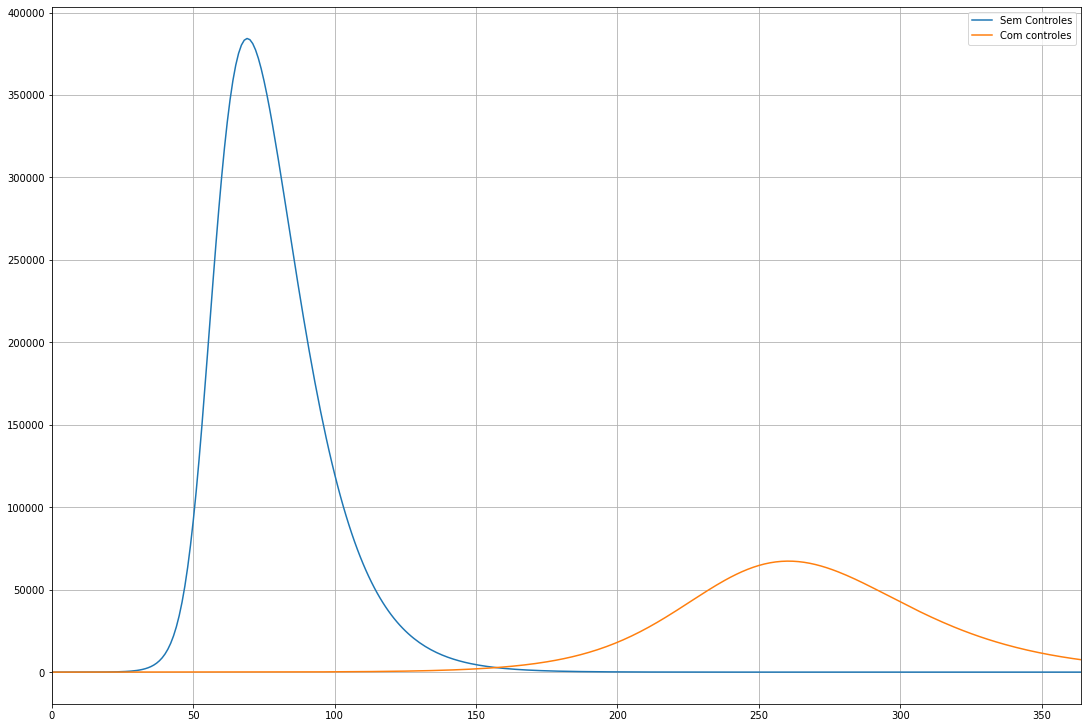

In [631]:
def save_data():
    fig,ax = subplots(1,1, figsize=(15,10), constrained_layout=True)
    χ=0.05;φ=.01;β=.25;ρ=.6;δ=.1;α=10; p=.75
    i=1
    dff = pd.DataFrame(data={'Sem controle':range(365),'Com controle':range(365)})
    for q,R0,c in [(0,3.6,'Sem controle'),(10,1.7,'Com controle')]:
        res = odeint(seqiahr,inits,trange,args=(q/100,φ,R0/10,ρ,δ,α,p))
        df = pd.DataFrame(data=res*N, columns=['S','E','I','A','H','R','C'],index=trange)
        ax = df[['H']].plot(ax=ax, grid=True)
        dff[c] =df.H
    plt.legend(['Sem Controles','Com controles'])
    plt.savefig(f'export/achatando a curva.png', dpi=300)
    dff.to_csv(f'export/achatando a curva.csv')

save_data()

## Carregando os dados do Brasil

In [10]:
# Pegando os casos do Brasil.io
cases = pd.read_csv('https://brasil.io/dataset/covid19/caso?format=csv')
cases.date = pd.to_datetime(cases.date)

In [11]:
df_states = cases[cases.place_type!='state'].groupby(['date','state']).sum()
df_states.reset_index(inplace=True)
df_states.set_index('date', inplace=True)

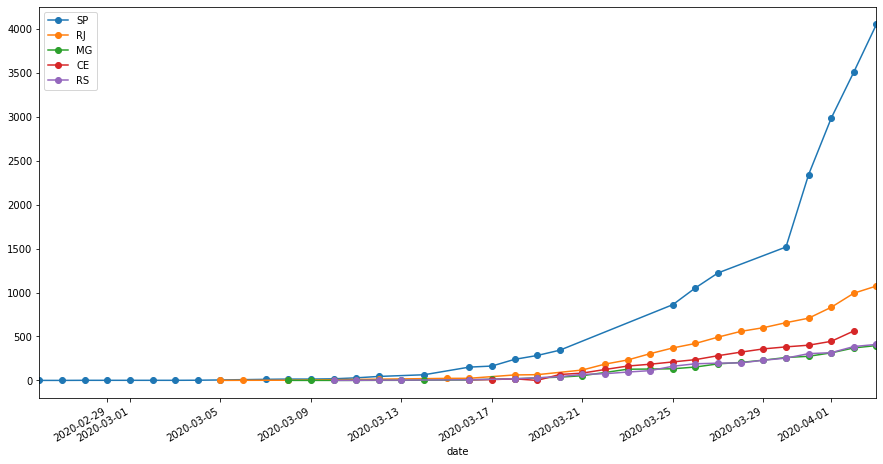

In [12]:
# df_states.set_index('date', inplace=True)
fig,ax = subplots(1,1,figsize=(15,8))
for uf in ['SP','RJ','MG','CE','RS']:
    df_states[df_states.state==uf].confirmed.plot(style='-o', label=uf)

ax.legend()
plt.savefig('export/Casos_confirmados_estados.png',dpi=200)

In [13]:
# Pegando os dados do Ministério
casos = pd.read_csv('COVID19_20200403.csv',sep=';')
casos.data = pd.to_datetime(casos.data, dayfirst=True)
casos_estados = casos.groupby(['data','estado']).sum()
casos_estados

casosNovos  casosAcumulados  obitosNovos  obitosAcumulados
data       estado                                                            
2020-01-30 AC               0                0            0                 0
           AL               0                0            0                 0
           AM               0                0            0                 0
           AP               0                0            0                 0
           BA               0                0            0                 0
...                       ...              ...          ...               ...
2020-04-03 RS              62              396            0                 5
           SC              34              281            3                 5
           SE               2               25            0                 2
           SP             542             4048           31               219
           TO               0               12            0                 0

[1755 rows x 4 columns]

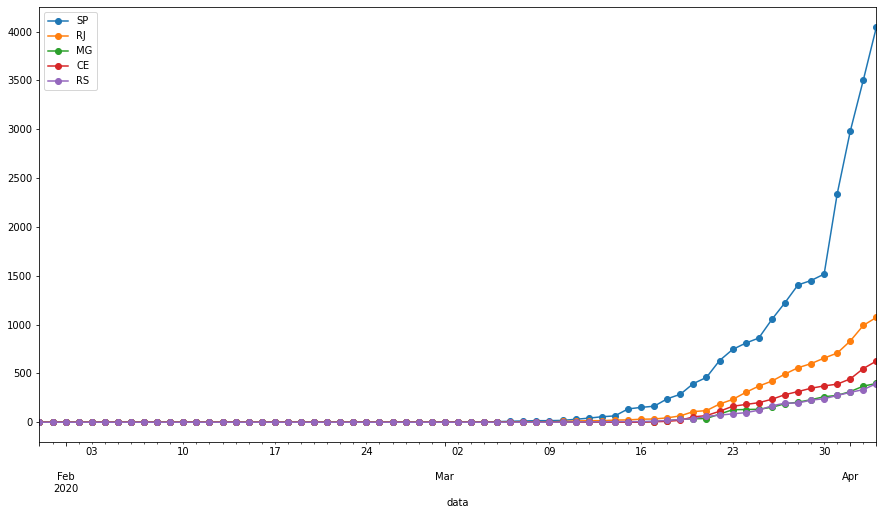

In [14]:
fig,ax = subplots(1,1,figsize=(15,8))
casos_estados.reset_index(inplace=True)
casos_estados.set_index('data', inplace=True)
for uf in ['SP','RJ','MG','CE','RS']:
    casos_estados[casos_estados.estado==uf].casosAcumulados.plot(style='-o', label=uf)

ax.legend()
plt.savefig('export/Casos_Acumulados_estados.png',dpi=200)

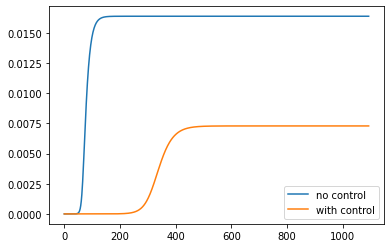

In [24]:
trange = arange(0,1095,1)
χ=0.0;φ=.01;β=.38;ρ=.6;δ=.1;α=10; p=.75; q=-2
inits = [0.99,0,1.0277e-8, 0.0,0,0,0]
res = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p,q))
# Com controle
χ=0.1;β=.17
res_c = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p,q))
plt.plot(trange,res[:,-1],label='no control');
plt.plot(trange,res_c[:,-1],label='with control');
plt.legend();

In [25]:
df_brasil = casos_estados.groupby('data').sum()
# df_brasil['casos_simulados']=res[:dias,-1]*N
# dfcp = df_brasil[['confirmed']]
# dfcp.to_csv('export/dados_brasil.csv')
df_brasil

,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
data,,,,
2020-01-30,0,0,0,0
2020-01-31,0,0,0,0
2020-02-01,0,0,0,0
2020-02-02,0,0,0,0
2020-02-03,0,0,0,0
...,...,...,...,...
2020-03-30,323,4579,23,159
2020-03-31,1138,5717,42,201
2020-04-01,1117,6834,40,241


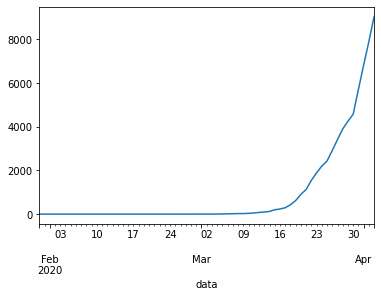

In [26]:
df_brasil.casosAcumulados.plot();

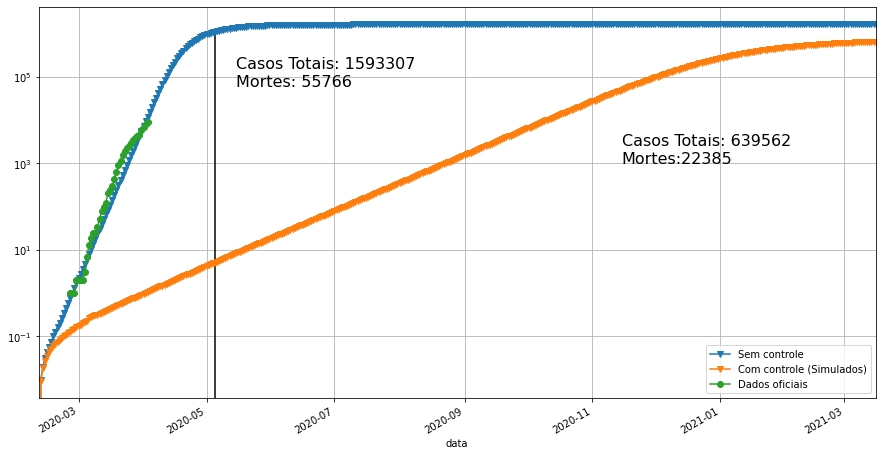

In [22]:
dias=400
offset = 15 # quantos dias antes do primeir caso notificado devemos começar a simulaçao
drange = pd.date_range(df_brasil[df_brasil.casosAcumulados>0].index.min()-timedelta(offset),periods=dias,freq='D')
# df_states.reset_index(inplace=True)
# df_brasil = df_states.groupby('date').sum()
fig,ax = subplots(1,1,figsize=(15,8))
ax.plot(drange,res[:dias,-1]*N,'-v', label='Sem controle')
# ax.plot(drange,res[:dias,-3]*N,'-v', label='Hosp')
ax.vlines('2020-05-5',0,1e6)
ax.plot(drange,res_c[:dias,-1]*N,'-v', label='Com controle (Simulados)')
# ax.plot(drange,res[:dias,2]*N,'-^', label='Prevalência')
df_brasil[df_brasil.casosAcumulados>0].casosAcumulados.plot(ax=ax, style='-o', 
                                                            label='Dados oficiais',
                                                            grid=True, 
                                                            logy=True)
# Sem controle
ax.text('2020-05-15',0.6e5, f'Casos Totais: {res[dias,-1]*N:.0f}\nMortes: {res[dias,-1]*N*fat:.0f}', 
        fontsize=16)
# com 10% quarentena e R0=1.7
ax.text('2020-11-15',1e3, f'Casos Totais: {res_c[dias,-1]*N:.0f}\nMortes:{res_c[dias,-1]*N*fat:.0f}', 
        fontsize=16)
ax.legend();
# plt.savefig('export/Casos_vs_Projeções_log.png',dpi=200)

In [19]:
df_sim = pd.DataFrame(data={'sem controle':res[:dias,-1]*N,'com controle':res_c[:dias,-1]*N}, index=drange)
df_sim.to_csv('export/simulação_brasil_com_e_sem_controle.csv')

## Comparando a série do Brasil com a de outros países

In [20]:
confirmed = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed = confirmed.groupby('Country/Region').sum()

In [21]:
confirmed

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,...,84,94,110,110,120,170,174,237,273,281
Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,...,146,174,186,197,212,223,243,259,277,304
Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,...,302,367,409,454,511,584,716,847,986,1171
Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,...,188,224,267,308,334,370,376,390,428,439
Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,...,3,4,4,5,7,7,7,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,6.4238,-66.5897,0,0,0,0,0,0,0,0,...,91,107,107,119,119,135,135,143,146,153
Vietnam,16.0000,108.0000,0,2,2,2,2,2,2,2,...,141,153,163,174,188,203,212,218,233,237
West Bank and Gaza,31.9522,35.2332,0,0,0,0,0,0,0,0,...,59,84,91,98,109,116,119,134,161,194


In [48]:
conf_US = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

In [49]:
conf_US

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,37,45,51,55,56,58,69,77,82,84
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,0,0,2,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,51,64,79,100,127,174,239,286,316,316
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,17,17,19,22,0,0,30,30,30,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,84090053,US,USA,840,90053.0,Unassigned,Washington,US,0.0000,0.0000,...,51,69,67,0,125,274,274,303,344,501
3249,84090054,US,USA,840,90054.0,Unassigned,West Virginia,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,0,0,61,0,0,0,0,0,0,0
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [50]:
conf_US.groupby('Country_Region').sum()

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
Country_Region,,,,,,,,,,,,,,,,,,,,,
US,272936469664,2730712,104327612.0,120958.868944,-290083.749251,1,1,2,2,5,...,65778,83836,101657,121478,140886,161807,188172,213362,243453,275582


In [51]:
serie_US = conf_US.groupby('Country_Region').sum().T
serie_US = serie_US.iloc[5:]
serie_US.index  = pd.to_datetime(serie_US.index)
serie_US.index.name = 'data'
# serie_US['acumulados'] = np.cumsum(serie_US.US)
serie_US

Country_Region,US
data,
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,2.0
2020-01-26,5.0
...,...
2020-03-30,161807.0
2020-03-31,188172.0
2020-04-01,213362.0


In [52]:
# outros = pd.DataFrame(data=)
suecia = confirmed.loc['Sweden'][2:]
alemanha = confirmed.loc['Germany'][2:]
espanha = confirmed.loc['Spain'][2:]
italia = confirmed.loc['Italy'][2:]
outros = pd.concat([suecia,alemanha,espanha,italia], axis=1)
outros.index = pd.to_datetime(outros.index)
# outros['Sweden_acc'] = np.cumsum(outros.Sweden)
# outros['Germany_acc'] = np.cumsum(outros.Germany)
# outros['Spain_acc'] = np.cumsum(outros.Spain)
# outros['Italy_acc'] = np.cumsum(outros.Italy)
outros

,Sweden,Germany,Spain,Italy
2020-01-22,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0
...,...,...,...,...
2020-03-30,4028.0,66885.0,87956.0,101739.0
2020-03-31,4435.0,71808.0,95923.0,105792.0
2020-04-01,4947.0,77872.0,104118.0,110574.0
2020-04-02,5568.0,84794.0,112065.0,115242.0


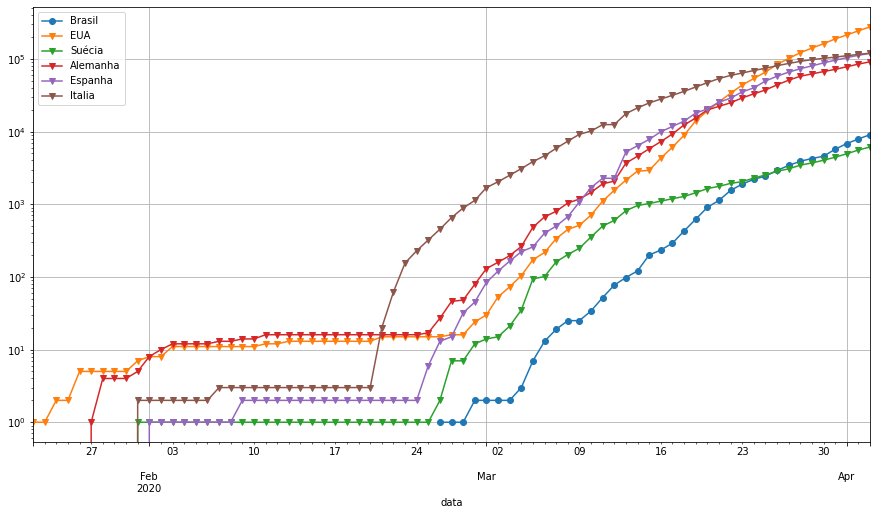

In [53]:
fig,ax = subplots(1,1,figsize=(15,8))
df_brasil[df_brasil.casosAcumulados>0].casosAcumulados.plot(ax=ax, style='-o', 
                                                            label='Brasil',
                                                            grid=True, 
                                                            logy=True)
serie_US.US.plot(ax=ax, style='-v', grid=True,
                        label='EUA',);
outros.Sweden.plot(ax=ax, style='-v', grid=True,
                        label='Suécia')
outros.Germany.plot(ax=ax, style='-v', grid=True,
                        label='Alemanha')
outros.Spain.plot(ax=ax, style='-v', grid=True,
                        label='Espanha')
outros.Italy.plot(ax=ax, style='-v', grid=True,
                        label='Italia')
ax.legend();

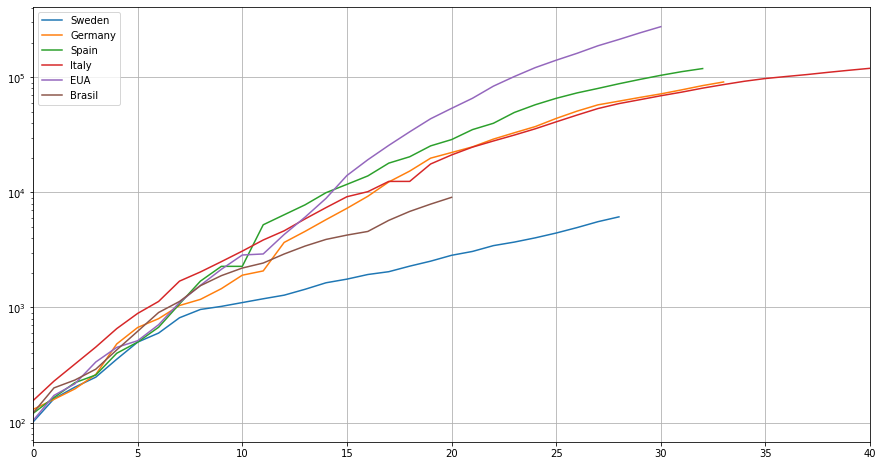

In [54]:
fig,ax = subplots(1,1,figsize=(15,8))
alinhados = pd.concat([suecia[suecia>100].reset_index(),
           alemanha[alemanha>100].reset_index(),
           espanha[espanha>100].reset_index(),
           italia[italia>100].reset_index()], 
          axis=1)
alinhados['EUA'] = serie_US[serie_US.US>100].reset_index().US
alinhados['Brasil'] = df_brasil[df_brasil.casosAcumulados>100].reset_index().casosAcumulados
alinhados.plot(ax=ax,logy=True, grid=True);
plt.savefig('export/Brasil_vs_outros.png', dpi=300)
alinhados.to_csv('export/Brasil_vs_outros.csv')

In [609]:
serie_US[serie_US.acumulados>100].reset_index().acumulados

0         109.0
1         120.0
2         131.0
3         142.0
4         154.0
5         166.0
6         179.0
7         192.0
8         205.0
9         218.0
10        231.0
11        244.0
12        257.0
13        270.0
14        285.0
15        300.0
16        315.0
17        330.0
18        345.0
19        360.0
20        376.0
21        392.0
22        416.0
23        446.0
24        499.0
25        572.0
26        676.0
27        848.0
28       1065.0
29       1401.0
30       1851.0
31       2365.0
32       3073.0
33       4178.0
34       5735.0
35       7882.0
36      10739.0
37      13657.0
38      17964.0
39      24060.0
40      32933.0
41      46957.0
42      66187.0
43      91814.0
44     125435.0
45     169098.0
46     222834.0
47     288612.0
48     372448.0
49     474105.0
50     595583.0
51     736469.0
52     898276.0
53    1086448.0
54    1299810.0
55    1543263.0
Name: acumulados, dtype: float64